# <center> Предобработка данных и логистическая регрессия для задачи бинарной классификации

**В данной работе будут разобраны основные техники предобработки данных, а так же обучение модели логистической регрессии.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn import  pipeline, preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import metrics

## Описание датасета

Задача: по 38 признакам, связанных с заявкой на грант (область исследований учёных, информация по их академическому бэкграунду, размер гранта, область, в которой он выдаётся) предсказать, будет ли заявка принята. Датасет включает в себя информацию по 6000 заявкам на гранты, которые были поданы в университете Мельбурна в период с 2004 по 2008 год.

In [3]:
data = pd.read_csv('data/data.csv')
data.shape

(6000, 39)

Выделим из датасета целевую переменную Grant.Status

In [4]:
X = data.drop('Grant.Status', axis = 1)
y = data['Grant.Status']

In [5]:
X.head()

,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,RFCD.Code.3,RFCD.Percentage.3,RFCD.Code.4,...,Dept.No..1,Faculty.No..1,With.PHD.1,No..of.Years.in.Uni.at.Time.of.Grant.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1,A..1,A.1,B.1,C.1
0,21A,50A,A,230202.0,50.0,230203.0,30.0,230204.0,20.0,0.0,...,3098.0,31.0,Yes,>=0 to 5,2.0,0.0,0.0,4.0,2.0,0.0
1,4D,10A,D,320801.0,100.0,0.0,0.0,0.0,0.0,0.0,...,2553.0,25.0,Yes,>=0 to 5,3.0,1.0,0.0,2.0,0.0,0.0
2,NaN,NaN,NaN,320602.0,50.0,321004.0,30.0,321015.0,20.0,0.0,...,2813.0,25.0,NaN,Less than 0,1.0,5.0,0.0,7.0,2.0,0.0
3,51C,20C,A,291503.0,60.0,321402.0,40.0,0.0,0.0,0.0,...,2553.0,25.0,NaN,more than 15,2.0,1.0,5.0,6.0,9.0,1.0
4,24D,30B,NaN,380107.0,100.0,0.0,0.0,0.0,0.0,0.0,...,2923.0,25.0,NaN,Less than 0,0.0,2.0,0.0,0.0,0.0,0.0


## Теория по логистической регрессии

Логистическая регрессия предсказывает вероятности принадлежности объекта к каждому классу. Сумма ответов логистической регрессии на одном объекте для всех классов равна единице.

$$ \sum_{k=1}^K \pi_{ik} = 1, \quad \pi_k \equiv P\,(y_i = k \mid x_i, \theta), $$

где:
- $\pi_{ik}$ - вероятность принадлежности объекта $x_i$ из выборки $X$ к классу $k$
- $\theta$ - внутренние параметры алгоритма, которые настраиваются в процессе обучения, в случае логистической регрессии - $w, b$

Из этого свойства модели в случае бинарной классификации требуется вычислить лишь вероятность принадлежности объекта к одному из классов (вторая вычисляется из условия нормировки вероятностей). Эта вероятность вычисляется, используя логистическую функцию:

$$ P\,(y_i = 1 \mid x_i, \theta) = \frac{1}{1 + \exp(-w^T x_i-b)} $$

Параметры $w$ и $b$ находятся, как решения следующей задачи оптимизации (указаны функционалы с L1 и L2 регуляризацией):

L2-regularization:

$$ Q(X, y, \theta) = \frac{1}{2} w^T w + C \sum_{i=1}^l \log ( 1 + \exp(-y_i (w^T x_i + b ) ) ) \longrightarrow \min\limits_{w,b} $$

L1-regularization:

$$ Q(X, y, \theta) = \sum_{d=1}^D |w_d| + C \sum_{i=1}^l \log ( 1 + \exp(-y_i (w^T x_i + b ) ) ) \longrightarrow \min\limits_{w,b} $$

$C$ - это стандартный гиперпараметр модели, который регулирует то, насколько сильно мы позволяем модели подстраиваться под данные.

## Предобработка данных

In [6]:
data.head()

,Grant.Status,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,RFCD.Code.3,RFCD.Percentage.3,...,Dept.No..1,Faculty.No..1,With.PHD.1,No..of.Years.in.Uni.at.Time.of.Grant.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1,A..1,A.1,B.1,C.1
0,1,21A,50A,A,230202.0,50.0,230203.0,30.0,230204.0,20.0,...,3098.0,31.0,Yes,>=0 to 5,2.0,0.0,0.0,4.0,2.0,0.0
1,1,4D,10A,D,320801.0,100.0,0.0,0.0,0.0,0.0,...,2553.0,25.0,Yes,>=0 to 5,3.0,1.0,0.0,2.0,0.0,0.0
2,0,NaN,NaN,NaN,320602.0,50.0,321004.0,30.0,321015.0,20.0,...,2813.0,25.0,NaN,Less than 0,1.0,5.0,0.0,7.0,2.0,0.0
3,0,51C,20C,A,291503.0,60.0,321402.0,40.0,0.0,0.0,...,2553.0,25.0,NaN,more than 15,2.0,1.0,5.0,6.0,9.0,1.0
4,0,24D,30B,NaN,380107.0,100.0,0.0,0.0,0.0,0.0,...,2923.0,25.0,NaN,Less than 0,0.0,2.0,0.0,0.0,0.0,0.0


Видно, что в датасете есть как числовые, так и категориальные признаки. Получим списки их названий:

In [7]:
numerical = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                'RFCD.Percentage.4', 'RFCD.Percentage.5',
                'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                'SEO.Percentage.4', 'SEO.Percentage.5',
                'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
categorical = list(set(X.columns.values.tolist()) - set(numerical))

Также в нём присутствуют пропущенные значения. Очевидным решением будет исключение всех данных, у которых пропущено хотя бы одно значение. Сделаем это:

In [8]:
X.dropna().shape

(213, 38)

Видно, что тогда мы выбросим почти все данные, и такой метод решения в данном случае не сработает.

Пропущенные значения можно так же интерпретировать, для этого существует несколько способов, они различаются для категориальных и вещественных признаков.

Для вещественных признаков:
- заменить на 0 (данный признак давать вклад в предсказание для данного объекта не будет)
- заменить на среднее (каждый пропущенный признак будет давать такой же вклад, как и среднее значение признака на датасете)

Для категориальных:
- интерпретировать пропущенное значение, как ещё одну категорию (данный способ является самым естественным, так как в случае категорий у нас есть уникальная возможность не потерять информацию о наличии пропущенных значений

## Обработка пропущенных значений.
1. Заполним пропущенные вещественные значения в X нулями и средними по столбцам, назовем полученные датафреймы **X_zeros** & **X_mean** соответственно.
2. Все категориальные признаки в X преобразуем в строки, пропущенные значения требуется также преобразовать в какие-либо строки, которые не являются категориями (например, 'NA').

In [9]:
X[categorical] = X[categorical]\
                        .fillna('NA')\
                        .astype(str)

In [10]:
# Пропущенные вещественые элементы заменяем на "0"
# (в категориальных все пропуски заполнены, соответственно, пропуски остались в вещественных факторах)
X_zero = X.fillna(0)

In [11]:
# Пропущенные вещественные элементы заменяем на среднее по столбцу
X_mean = X.fillna(X[numerical].mean())

Для использования модели регрессии требуется преобразовать категориальные признаки в вещественные. Основной способ преоборазования категориальных признаков в вещественные: one-hot encoding. 

Для построения метрики качества по результату обучения требуется разделить исходный датасет на обучающую и тестовую выборки.

In [12]:
from sklearn.model_selection import train_test_split

(X_train_zero, 
 X_test_zero,
 X_train_mean,
 X_test_mean,
 y_train,
 y_test) = train_test_split(X_zero, 
                            X_mean, 
                            y, 
                            test_size = 0.3, 
                            random_state = 0)


## Сравнение способов заполнения вещественных пропущенных значений.
1. Составим две обучающие выборки: в первой - пропущенные вещественные значения заполнены нулями, в другой - средними.
2. Обучим на них логистическую регрессию, используя gridsearch для подбора оптимальных параметров
3. Построим два графика оценок точности +- их стандратное отклонение в зависимости от гиперпараметра и убедимся, что действительно нашли оптимальные параметры. 

In [13]:
def plot_scores(optimizer):
    scores=[]
    for i in range(len(optimizer.cv_results_['params'])):
        scores.append([optimizer.cv_results_['params'][i]['model_fit__C'], 
                optimizer.cv_results_['mean_test_score'][i],
                optimizer.cv_results_['std_test_score'][i]])
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.show()

**Напишем фунцию, которая определит оптимальные гипермараметры для логистической регрессии и обучит модель.**

Функция возвращает лист в котором содержатся: 
* Самый высокий скор поиска по сетки (ROC AUC)
* Модель логистической регрессии (имеет наивысший скор по качеству)
* Результаты поиска по сетке.


In [14]:
def LR_model_1(X, y):
    
    LR = LogisticRegression(random_state = 20, class_weight = None, n_jobs = -1)
    
    model = pipeline.Pipeline(steps = [ 
                    ('feature_preparation', pipeline.FeatureUnion(transformer_list = [        
                            #numerical
                            ('numerical_values', preprocessing.FunctionTransformer(lambda data: data.loc[:, numerical])), 

                            #categorical
                            ('categorical_values', pipeline.Pipeline(steps = [
                                ('selecting', preprocessing.FunctionTransformer(lambda data: data.loc[:,categorical])),
                                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                                        ])),
                        ])),
                    ('model_fit', LR)
                    ]
            )
    params_grid = {'model_fit__C' : np.logspace(-3,1,15)}

    optimizer = GridSearchCV(model, params_grid, scoring = 'roc_auc', cv = 5, n_jobs = -1)
    
    optimizer.fit(X, y)
    
    best_score = optimizer.best_score_
    best_estimator = optimizer.best_estimator_
    
    return [best_score, best_estimator, optimizer]

In [15]:
# Применим функцию LR_model_1 к двум датасетам, в первом пропуски заменили нулями, во втором использовали замену средним значением
optimizer_zero = LR_model_1(X_zero, y)
optimizer_mean = LR_model_1(X_mean, y)

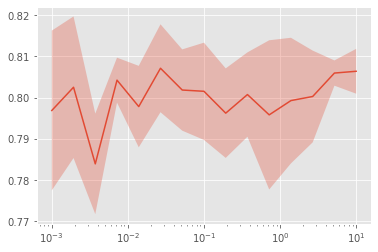

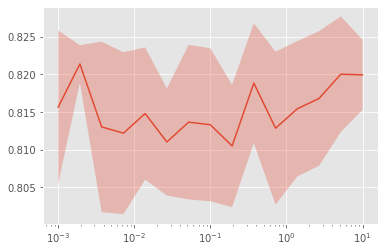

In [16]:
# Графики оценок ROC AUC +- st.dev в зависимости от гиперпараметра
plot_scores(optimizer_zero[2])
plot_scores(optimizer_mean[2])

In [17]:
print(f'ROC AUC zero = {np.round(optimizer_zero[0],10)} - кросс валидационная оценка качества модели')
print(f'ROC AUC mean = {np.round(optimizer_mean[0],10)} - кросс валидационная оценка качества модели')

ROC AUC zero = 0.8070887898 - кросс валидационная оценка качества модели
ROC AUC mean = 0.8213799114 - кросс валидационная оценка качества модели


**Результаты продемонстрировали, что замена пропусков средним оптимальнее,таким образом в дальнейшем будем использовать X_num_mean, но этот случай относится конкретно к нашей ситуации, все зависит от специфики задачи и данных, в других задачах может быть и такое, что замена пропусков нулями даст более высокую точность нежели замена средним, а то и вовсе выгоднее заменить пропуски медианой (если по признакам присутствуют выбросы)**

Вспомогательная функция **roc_auc**, выполняющая следующие задачи:
* Обучает логит-модель & feature_preparation на трейне
* Трансформирует тестовую выборку (работа с категориальными и везественными переменными) 
* Считает ROC AUC на тестовой и обучающей выборке. 

На вход подается:
* model - (**LR_model**, ранее реализованная ф-я для поиска гиперпараметров и обучения логит модели)
* X_train
* X_test
* y_train
* y_test

Возвращает:
* ROC AUC на тесте
* Качество модели на кросс-валидации (обучающая выборка)
* Вероятность принадлежности объектов к классу 1
* Предсказание класса для каждого наблюдения

In [18]:
def roc_auc(model, X_train, y_train, X_test, y_test):
    
    # Обучим на трейне логит-модель, feature_preparation и подберем оптимальные параметры.
    optimizer = model(X_train, y_train)
    
    # Обученная логит-модель
    LR = optimizer[1]['model_fit']
    
    # Преобразуем тестовый датасет с помощью обученного на трейне feature_preparation
    X_test = optimizer[1]['feature_preparation'].transform(X_test)
    
    # Обученную логит-модель применяем к тестовой выборке, предсказываем тестовый таргет
    y_predict = LR.predict_proba(X_test)
    y_predict_class = LR.predict(X_test)
    
    # ROC AUC на тесте
    auc_score_test = np.round(roc_auc_score(y_test, y_predict[:,1]),3)
    
    # Качество модели на кросс-валидации
    auc_score_cross_vall_score = np.round(optimizer[0],3)
    
    return [auc_score_test,auc_score_cross_vall_score, y_predict[:,1], y_predict_class]

In [19]:
roc_auc_scores_1 = roc_auc(LR_model_1, X_train_mean, y_train, X_test_mean, y_test)

In [20]:
print(f'ROC AUC  = {roc_auc_scores_1[0]} на тесте')

ROC AUC  = 0.805 на тесте


In [21]:
print(f'ROC AUC  = {roc_auc_scores_1[1]} - кросс валидационная оценка модели на трейнe')

ROC AUC  = 0.813 - кросс валидационная оценка модели на трейнe


Результаты:

**ROC AUC test = 0.812**

**ROC AUC cross_val_score = 0.812**

## Масштабирование вещественных признаков.

Попробуем как-то улучшить качество классификации. Для этого посмотрим на сами данные:

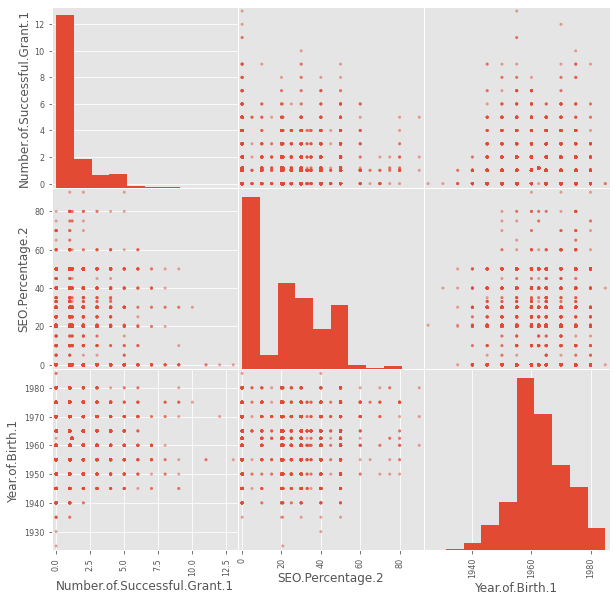

In [22]:
data_numeric = pd.DataFrame(X_train_mean, columns=numerical)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
pd.plotting.scatter_matrix(data_numeric[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

Как видно из графиков, разные признаки очень сильно отличаются друг от друга по модулю значений (обратите внимание на диапазоны значений осей x и y). В случае обычной регрессии это никак не влияет на качество обучаемой модели, т.к. у меньших по модулю признаков будут большие веса, но при использовании регуляризации, которая штрафует модель за большие веса, регрессия, как правило, начинает работать хуже.

В таких случаях всегда рекомендуется делать стандартизацию (масштабирование) признаков, для того чтобы они меньше отличались друг друга по модулю, но при этом не нарушались никакие другие свойства признакового пространства. При этом даже если итоговое качество модели на тесте уменьшается, это повышает её интерпретабельность, потому что новые веса имеют смысл "значимости" данного признака для итоговой классификации.

Стандартизация осуществляется посредством вычета из каждого признака среднего значения и нормировки на выборочное стандартное отклонение:

$$ x^{scaled}_{id} = \dfrac{x_{id} - \mu_d}{\sigma_d}, \quad \mu_d = \frac{1}{N} \sum_{i=1}^l x_{id}, \quad \sigma_d = \sqrt{\frac{1}{N-1} \sum_{i=1}^l (x_{id} - \mu_d)^2} $$

In [23]:
# Модифицируем функцию LR_model_1, добавив масшабирование вещественных переменных
def LR_model_2(X, y):
    
    LR = LogisticRegression(random_state = 20, class_weight = None, n_jobs = -1)
    
    model = pipeline.Pipeline(steps = [ 
                    ('feature_preparation', pipeline.FeatureUnion(transformer_list = [   
                            #numerical. Добавили масштабирование
                            ('numerical_values', pipeline.Pipeline(steps = [
                                ('selecting', preprocessing.FunctionTransformer(lambda data: data.loc[:, numerical])),
                                ('scaling', preprocessing.StandardScaler())            
                                        ])), 
                            #categorical
                            ('categorical_values', pipeline.Pipeline(steps = [
                                ('selecting', preprocessing.FunctionTransformer(lambda data: data.loc[:,categorical])),
                                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                                        ])),
                        ])),
                    ('model_fit', LR)
                    ]
            )
    params_grid = {'model_fit__C' : np.logspace(-3,1,15)}

    optimizer = GridSearchCV(model, params_grid,  cv = 5, n_jobs = -1)
    
    optimizer.fit(X, y)
    
    best_score = optimizer.best_score_
    best_estimator = optimizer.best_estimator_
    
    return [best_score, best_estimator, optimizer]

In [24]:
roc_auc_scores_2 = roc_auc(LR_model_2, X_train_mean, y_train, X_test_mean, y_test)

In [25]:
print(f'ROC AUC = {roc_auc_scores_2[0]} на тесте')

ROC AUC = 0.888 на тесте


In [26]:
print(f'ROC AUC = {roc_auc_scores_2[1]} - кросс валидационная оценка модели на трейнe')

ROC AUC = 0.798 - кросс валидационная оценка модели на трейнe


**Применив масштабирование вещественных факторов, мы значительно улучшили качество модели!**

Результаты:

**ROC AUC test = 0.888**

**ROC AUC cross_val_score = 0.798**

## Балансировка классов и Стратификация выборок.

Алгоритмы классификации могут быть очень чувствительны к несбалансированным классам.
Посмотрим, сбалансированны ли классы в нашей обучающей выборке:

In [27]:
print(np.sum(y_train==0))
print(np.sum(y_train==1))

2316
1884


Видно, что нет.

Кроме того, необходимо при разбиении на трейн и тест учитывать соотношение выборок, т.к может быть и такое, что в трейне соотношение 75 на 25, а в тесте 90 на 10, что не ведет к оптимальной оценке качества модели.

In [28]:
# Модифицируем функцию LR_model_2, добавив балансировку классов
def LR_model_3(X, y):
    
    # Добавили Балансировку классов
    LR = LogisticRegression(random_state = 20, class_weight = 'balanced', n_jobs = -1)

    model = pipeline.Pipeline(steps = [ 
                    ('feature_preparation', pipeline.FeatureUnion(transformer_list = [   
                            #numerical.
                            ('numerical_values', pipeline.Pipeline(steps = [
                                ('selecting', preprocessing.FunctionTransformer(lambda data: data.loc[:, numerical])),
                                ('scaling', preprocessing.StandardScaler())            
                                        ])), 
                            #categorical
                            ('categorical_values', pipeline.Pipeline(steps = [
                                ('selecting', preprocessing.FunctionTransformer(lambda data: data.loc[:,categorical])),
                                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                                        ])),
                        ])),
                    ('model_fit', LR)
                    ]
            )
    params_grid = {'model_fit__C' : np.logspace(-3,1,15)}

    optimizer = GridSearchCV(model, params_grid, scoring = 'roc_auc', cv = 5, n_jobs = -1)
    
    optimizer.fit(X, y)
    
    best_score = optimizer.best_score_
    best_estimator = optimizer.best_estimator_
    
    return [best_score, best_estimator, optimizer]

In [29]:
# При разбиении учитываем соотношение классов таргета.

(X_train_mean, 
 X_test_mean,
 y_train, 
 y_test) = train_test_split(X_mean, 
                            y, 
                            test_size = 0.3, 
                            random_state = 0,
                            stratify = y)


In [30]:
roc_auc_scores_3 = roc_auc(LR_model_3, X_train_mean, y_train, X_test_mean, y_test)

In [31]:
print(f'ROC AUC = {roc_auc_scores_3[0]} на тесте')

ROC AUC = 0.877 на тесте


In [32]:
print(f'ROC AUC = {roc_auc_scores_3[1]} - кросс валидационная оценка модели на трейнe')

ROC AUC = 0.882 - кросс валидационная оценка модели на трейнe


**Как мы видим, качество на тесте уменьшилось, но незначительно. При этом, в зависимости от того, как мы разбили изначально данные на обучение и тест, после сбалансированного разделения выборок итоговая метрика на тесте может как увеличиться, так и уменьшиться, но доверять ей можно значительно больше, т.к. она построена с учётом специфики работы классификатора.**

Результаты:

**ROC AUC test = 0.877**

**ROC AUC cross_val_score = 0.882**

Теперь мы разобрались с основными этапами предобработки данных для линейных классификаторов:
- обработка пропущенных значений
- обработка категориальных признаков
- стратификация
- балансировка классов
- масштабирование

## Трансформация признаков.

Теперь рассмотрим способы преобразования признаков. Существует достаточно много различных способов трансформации признаков, которые позволяют при помощи линейных методов получать более сложные разделяющие поверхности. Самым базовым является полиномиальное преобразование признаков. Его идея заключается в том, что помимо самих признаков вы дополнительно включаете набор все полиномы степени $p$, которые можно из них построить. Для случая $p=2$ преобразование выглядит следующим образом:

$$ \phi(x_i) = [x_{i,1}^2, ..., x_{i,D}^2, x_{i,1}x_{i,2}, ..., x_{i,D} x_{i,D-1}, x_{i,1}, ..., x_{i,D}, 1] $$

Но при этом одновременно данный метод способствует более сильной способности модели к переобучению из-за быстрого роста числа признаком с увеличением степени $p$

In [33]:
# Модифицируем функцию LR_model_3, добавив полиномы второй степени
def LR_model_4(X, y):
    
    LR = LogisticRegression(random_state = 20, class_weight = 'balanced', n_jobs = -1)
    
    model = pipeline.Pipeline(steps = [ 
                    ('feature_preparation', pipeline.FeatureUnion(transformer_list = [   
                            #numerical.
                            ('numerical_values', pipeline.Pipeline(steps = [
                                ('selecting', preprocessing.FunctionTransformer(lambda data: data.loc[:, numerical])),
                                # Добавили полиномы
                                ('polynomial',preprocessing.PolynomialFeatures(2)),
                                ('scaling', preprocessing.StandardScaler())            
                                        ])), 
                            #categorical
                            ('categorical_values', pipeline.Pipeline(steps = [
                                ('selecting', preprocessing.FunctionTransformer(lambda data: data.loc[:,categorical])),
                                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                                        ])),
                        ])),
                    ('model_fit', LR)
                    ]
            )
    params_grid = {'model_fit__C' : np.logspace(-3,1,15)}

    optimizer = GridSearchCV(model, params_grid, scoring = 'roc_auc', cv = 5, n_jobs = -1)
    
    optimizer.fit(X, y)
    
    best_score = optimizer.best_score_
    best_estimator = optimizer.best_estimator_
    
    return [best_score, best_estimator, optimizer]

In [34]:
roc_auc_scores_4 = roc_auc(LR_model_4, X_train_mean, y_train, X_test_mean, y_test)

In [35]:
print(f'ROC AUC = {roc_auc_scores_4[0]} на тесте')

ROC AUC = 0.886 на тесте


In [36]:
print(f'ROC AUC = {roc_auc_scores_4[1]} - кросс валидационная оценка модели на трейнe')

ROC AUC = 0.887 - кросс валидационная оценка модели на трейнe


Результаты:

**ROC AUC test = 0.886**

**ROC AUC cross_val_score = 0.887**

**Результаты нам говорят о следующем, полиномиальное преобразование признаков положительно сказалось на качестве, увеличился скор как на валидации, так и на тесте!**

Text(0, 0.5, 'True Positive Rate')

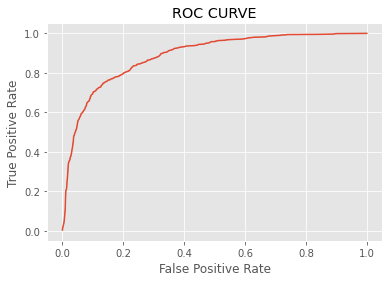

In [37]:
fig, axes = plt.subplots(1,1)
fpr, tpr, thr = roc_curve(y_test,roc_auc_scores_4[2])
sns.lineplot(fpr,tpr, ax = axes)
axes.set_title('ROC CURVE')
axes.set_xlabel('False Positive Rate')
axes.set_ylabel('True Positive Rate')

In [38]:
print(f'recall = {np.round(metrics.recall_score(y_test, roc_auc_scores_4[3], pos_label = 0),3)}')
print(f'precision = {np.round(metrics.precision_score(y_test, roc_auc_scores_4[3], pos_label = 0),3)}')

recall = 0.799
precision = 0.825


In [39]:
confusion_matrix = pd.DataFrame({'predicted negative': metrics.confusion_matrix(y_test,roc_auc_scores_4[3])[:, 0],
                                'predicted positive': metrics.confusion_matrix(y_test, roc_auc_scores_4[3])[:, 1]})
confusion_matrix.index = ['actual negative', 'actual positive']
confusion_matrix

,predicted negative,predicted positive
actual negative,781,197
actual positive,166,656


## Заключение
* Обучена логит-модель, предсказывающая вероятность принятия заявки на грант.
* Резульаты на тестовой выборке:
  * **ROC AUC = 0.89**
  * **Precision = 0.83**
  * **Recall = 0.80**
* На практическом примере продемонстрирована необходимость предобработки данных
  * Обработка пропущенных значений
  * Обработка категориальных признаков
  * Стратификация
  * Балансировка классов
  * Масштабирование
  * Полиномиальное преобразование признаков (как бонус)